In [1]:
import tensorflow as tf
import pandas as pd
from window import WindowGenerator
import utils

# LSTM

## Datasets

In [2]:
case_1 = pd.read_csv("../datasets/case_1.csv")
case_2 = pd.read_csv("../datasets/case_2.csv")
case_3 = pd.read_csv("../datasets/case_3.csv")
case_4 = pd.read_csv("../datasets/case_4.csv")
case_5 = pd.read_csv("../datasets/case_5.csv")

In [3]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

num_features = len(label_columns)

In [4]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [5]:
def train_case(case_df:pd.DataFrame, model, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case dataframe. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = utils.train_test_val_split(case_df, test_size=0, val_size=0.2)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Model creation

In [6]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 150
features_size = len(label_columns)

In [7]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-24 12:24:52.266358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-24 12:24:52.266480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

## Case 2

In [9]:
window, history = train_case(
    case_df=case_2,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

2022-09-24 12:24:52.894976: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-24 12:24:53.908577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 12:24:54.085323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 12:24:54.427812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 12:24:55.044679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 12:24:55.113386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [10]:
multi_lstm_model.build(input_shape=window.example[0].shape)
multi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                39168     
                                                                 
 dense (Dense)               (None, 2448)              80784     
                                                                 
 reshape (Reshape)           (None, 18, 136)           0         
                                                                 
Total params: 119,952
Trainable params: 119,952
Non-trainable params: 0
_________________________________________________________________


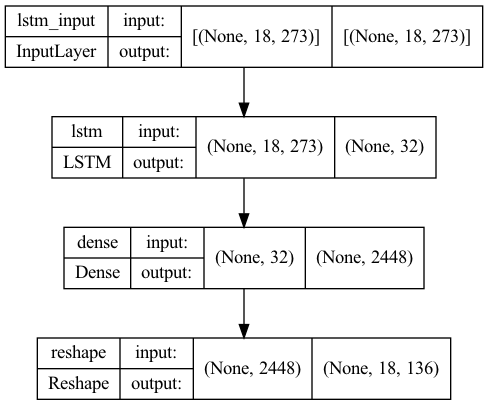

In [11]:
tf.keras.utils.plot_model(multi_lstm_model, "../plots/models/multi_lstm_model.png", show_shapes=True)

label_col_index 135


2022-09-24 12:25:58.533343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-24 12:25:58.590678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135
label_col_index 135


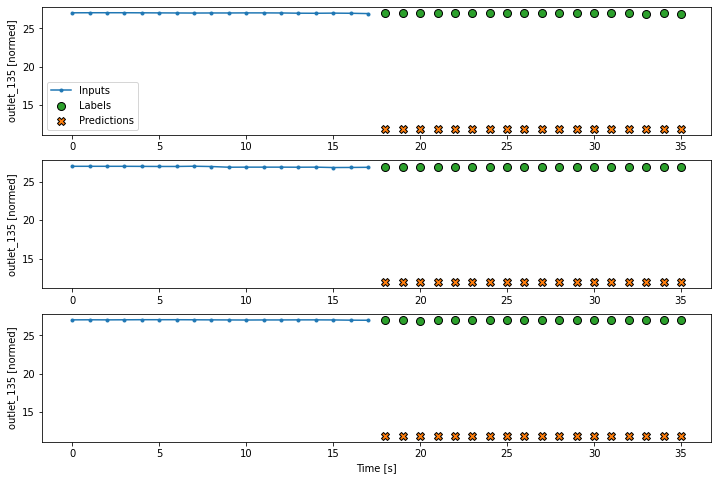

In [12]:
window.plot(multi_lstm_model, plot_col="outlet_135")

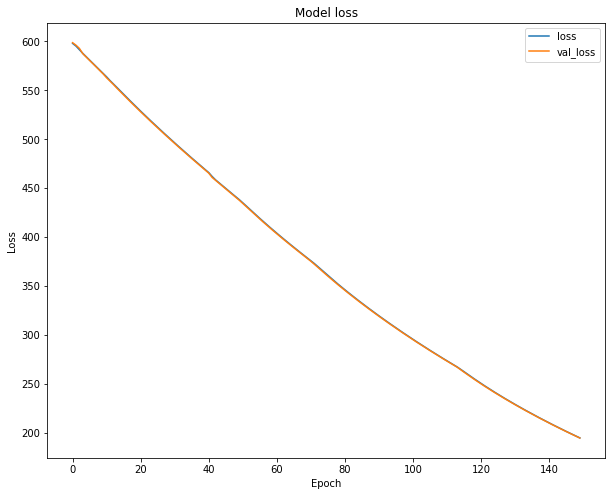

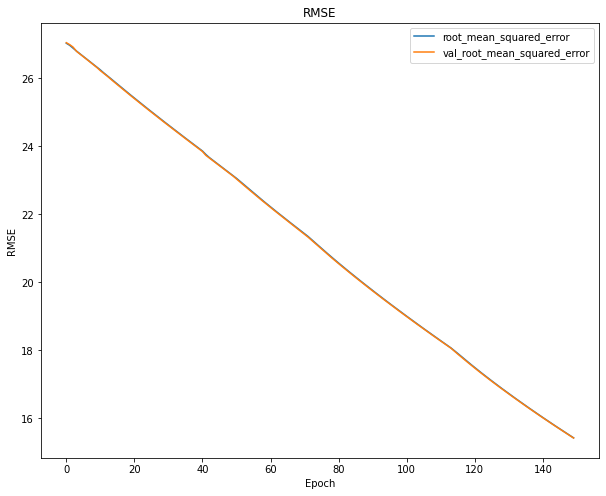

In [13]:
utils.plot_losses(history=history)

## Case 3

In [14]:
window, history = train_case(
    case_df=case_3,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


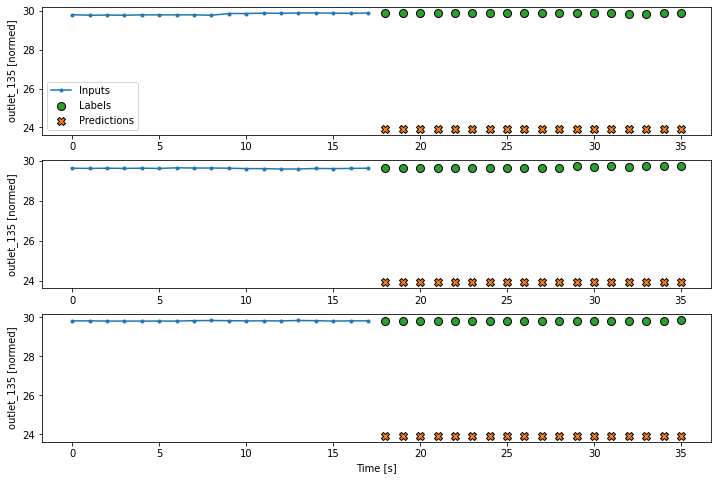

In [15]:
window.plot(multi_lstm_model, plot_col="outlet_135")

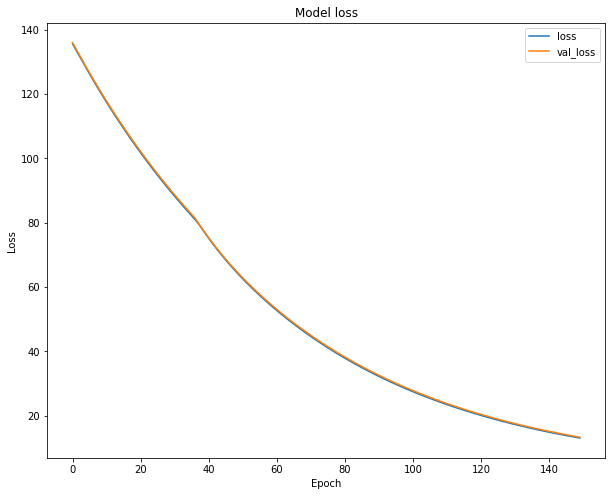

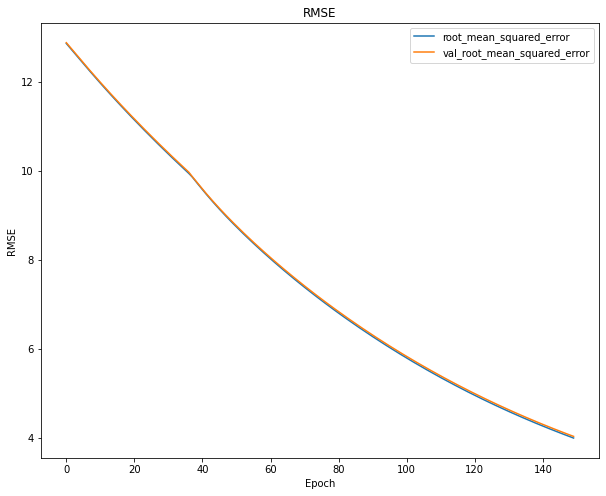

In [16]:
utils.plot_losses(history=history)

## Case 4

In [17]:
window, history = train_case(
    case_df=case_4,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


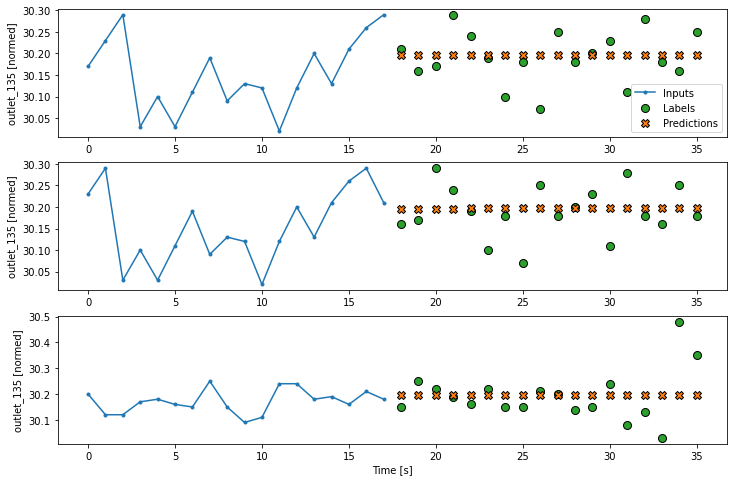

In [18]:
window.plot(multi_lstm_model, plot_col="outlet_135")

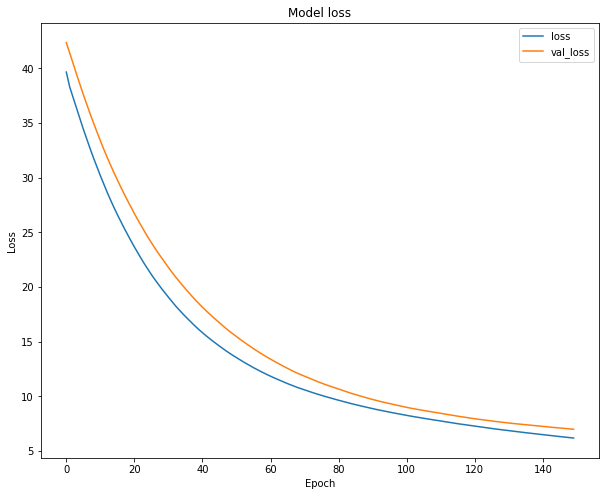

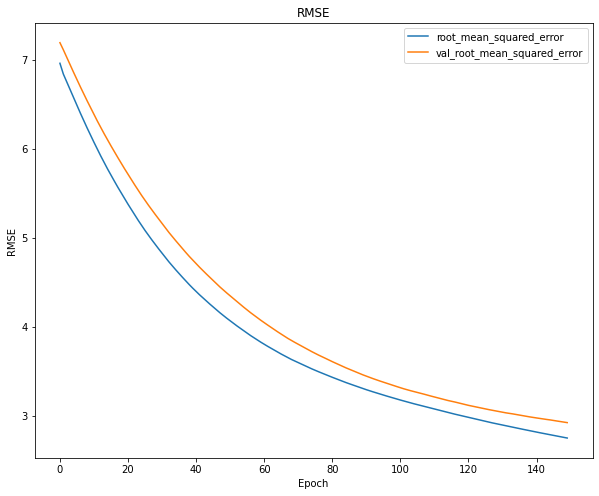

In [19]:
utils.plot_losses(history=history)

## Case 5

In [20]:
window, history = train_case(
    case_df=case_5,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


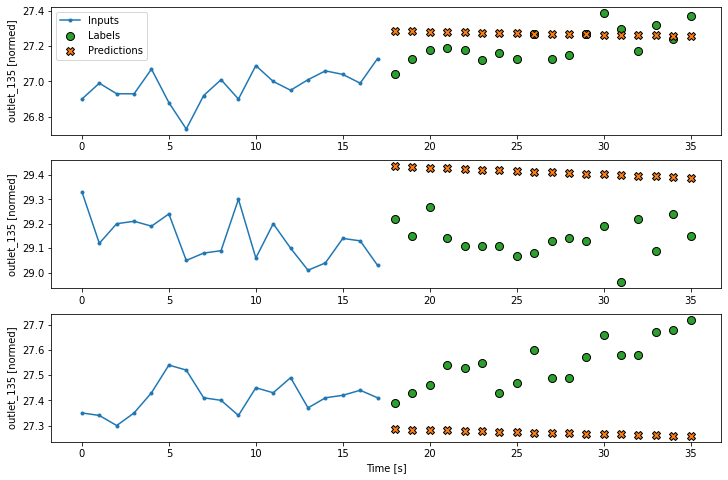

In [21]:
window.plot(multi_lstm_model, plot_col="outlet_135")

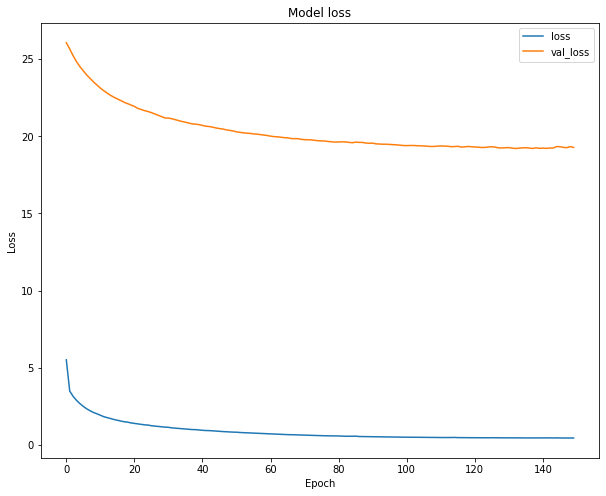

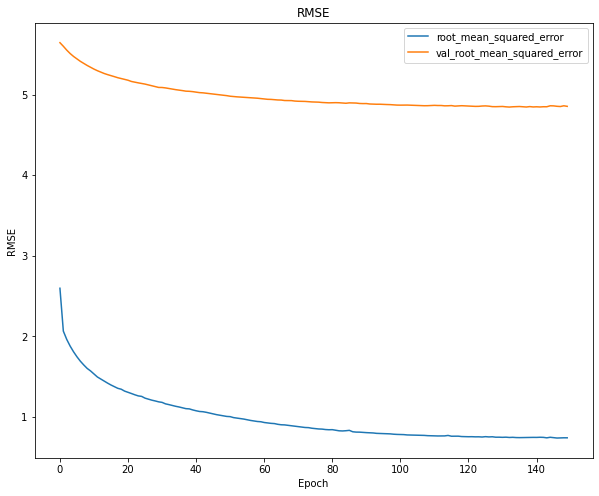

In [22]:
utils.plot_losses(history=history)

## Case 1 (Testing)

In [23]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

label_columns = outlets

window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=label_columns
)

multi_lstm_model.evaluate(window.train)

5/5 [==============================] - 0s 13ms/step - loss: 41.3406 - root_mean_squared_error: 7.1091


[41.34060287475586, 7.10908842086792]